## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A / B tests are very commonly performed by data analysts and data scientists.

In this project, I will be working to understand the results of an A / B test run by an e-commerce website. The goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.


<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [3]:
df.shape

(294478, 5)

> **The number of rows in the dataset is `294478`**

c. The number of unique users in the dataset.

In [4]:
df['user_id'].nunique()

290584

> **The number of unique users in the dataset is `290584`**

d. The proportion of users converted.

In [5]:
df['converted'].mean()

0.11965919355605512

> **The proportion of users converted is about `12%`**

e. The number of times the `new_page` and `treatment` don't line up.

In [6]:
# We should count all the cases except the group is 'treatment' and the landing page is a 'new_page', then we add them together.
treatment_oldpage = df.query('group == "treatment" and landing_page == "old_page"')['user_id'].count()
control_newpage = df.query('group == "control" and landing_page == "new_page"')['user_id'].count()
no_newpage_treatment = treatment_oldpage + control_newpage
no_newpage_treatment

3893

> **The number of times the new_page and treatment don't match is `3893`**

f. Do any of the rows have missing values?

In [7]:
# check for null values
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

> **There are no rows have null or missing values**

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [8]:
# we should delete these rows
df.drop(df.query('group == "treatment" and landing_page == "old_page"').index, inplace = True)
df.drop(df.query('group == "control" and landing_page == "new_page"').index, inplace = True)

In [9]:
# save it to new dataset
df.to_csv('ab_data_edited.csv', index = False)

In [10]:
# read the dataset and assign it to new dataframe
df2 = pd.read_csv('ab_data_edited.csv')
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [11]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [12]:
df2['user_id'].nunique()

290584

> **The number of unique IDs is `290584`**

b. There is one **user_id** repeated in **df2**.  What is it?

In [13]:
df2[df2['user_id'].duplicated()]

,user_id,timestamp,group,landing_page,converted
2862,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


> **The user_id for the non-unique ID is `773192`**

c. What is the row information for the repeat **user_id**? 

In [14]:
df2.query('user_id == 773192')

,user_id,timestamp,group,landing_page,converted
1876,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2862,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


> - **The user_id for the non-unique id is `773192`**
> - **The group for the non-unique id is `treatment`**
> - **The landing_page for the non-unique id is `new_page`**
> - **The value of converted column for the non-unique id is `0`** 

d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [15]:
# drop the second user id which is in index #2862
df2.drop([2862], inplace = True)

In [16]:
# check if the row deleted
df2.query('user_id == 773192')

,user_id,timestamp,group,landing_page,converted
1876,773192,2017-01-09 05:37:58.781806,treatment,new_page,0


`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [17]:
# converted average for both pages
df2['converted'].mean()

0.11959708724499628

> **The probability of converting regardless of page is `0.1196`**

b. Given that an individual was in the `control` group, what is the probability they converted?

In [18]:
# converted average for control group "P(converted|control)"
control_conv_prop = df2.query('group == "control"')['converted'].mean()
control_conv_prop

0.1203863045004612

> **Given that an individual was in the control group, the probability of converting is `0.1204`**

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [19]:
# converted average for treatment group "P(converted|treatment)"
treatment_conv_prop = df2.query('group == "treatment"')['converted'].mean()
treatment_conv_prop

0.11880806551510564

> **Given that an individual was in the treatment group, the probability of converting is `0.1188`**

d. What is the probability that an individual received the new page?

In [20]:
df2.query('landing_page == "new_page"')['user_id'].count() / df2.shape[0]

0.5000619442226688

> **The probability of receiving the new page is `0.5001`**

e. Consider your results from a. through d. above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.

> **The conversion probability of the control group is `0.1204` which is higher than the conversion probability of the treatment group `0.1188`, but we still cannot decide which page is better than other, because the difference between them is very low and we have to test other factors to get the sufficient evidence.**

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

$$H_0: p_{new} \leq p_{old}$$

$$H_1: p_{new} > p_{old}$$

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [21]:
p_new = df2['converted'].mean()
p_new

0.11959708724499628

> **The convert rate for $p_{new}$ under the null is about `0.1196`**

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [22]:
p_old = df2['converted'].mean()
p_old

0.11959708724499628

> **The convert rate for $p_{old}$ under the null is about `0.1196`**

c. What is $n_{new}$?

In [23]:
n_new = df2.query('landing_page == "new_page"')['converted'].count()
n_new

145310

> **The $n_{new}$ is `145310`**

d. What is $n_{old}$?

In [24]:
n_old = df2.query('landing_page == "old_page"')['converted'].count()
n_old

145274

> **The $n_{old}$ is `145274`**

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [25]:
new_page_converted = np.random.choice([0, 1], size = n_new, p = [(p_new), (1 - p_new)])
new_page_converted, new_page_converted.mean()

(array([1, 1, 1, ..., 1, 1, 1]), 0.8811988163237217)

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [26]:
old_page_converted = np.random.choice([0, 1], size = n_old, p = [(p_old), (1 - p_old)])
old_page_converted, old_page_converted.mean()

(array([1, 1, 1, ..., 1, 1, 1]), 0.8798477360023129)

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [27]:
diff_page_converted = new_page_converted.mean() - old_page_converted.mean()
diff_page_converted

0.0013510803214087375

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [28]:
# simulate 10,000 times
p_diffs = []
for i in range(10000):
    new_page_converted = np.random.choice([0, 1], size = n_new, p = [(1 - p_new), (p_new)])
    old_page_converted = np.random.choice([0, 1], size = n_old, p = [(1 - p_old), (p_old)])
    p_diffs.append(new_page_converted.mean() - old_page_converted.mean())
np.mean(p_diffs)

-2.450330164595281e-06

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

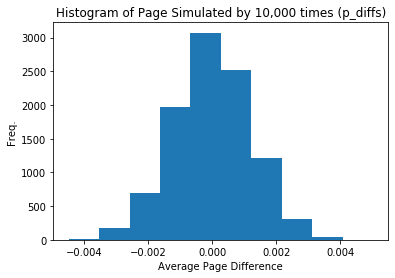

In [29]:
# plot distribution
plt.hist(p_diffs)
plt.title('Histogram of Page Simulated by 10,000 times (p_diffs)')
plt.xlabel('Average Page Difference')
plt.ylabel('Freq.');

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [30]:
# convert to numpy array
p_diffs = np.array(p_diffs)

In [31]:
# we have to compute the difference observed
obs_diff = treatment_conv_prop - control_conv_prop
obs_diff

-0.0015782389853555567

In [32]:
(obs_diff < p_diffs).mean()

0.9032

k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

> **In part j, we have computed the p-value**

> **Since the p-value is `0.903` which is high value and greater than 0.5 (alpha), it suggests that we fail to reject the null hypothesis, which means the new page is equal or worst than the old page.**

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [33]:
import statsmodels.api as sm

convert_old = df2.query('group == "control"')['converted'].sum()
convert_new = df2.query('group == "treatment"')['converted'].sum()
n_old = df2.query('landing_page == "old_page"')['converted'].count()
n_new = df2.query('landing_page == "new_page"')['converted'].count()
convert_old, convert_new, n_old, n_new

(17489, 17264, 145274, 145310)

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [34]:
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative = 'smaller')
z_score, p_value

(1.3109241984234394, 0.9050583127590245)

> **z-score is `1.31`**

> **p-value is `0.905`**

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

In [35]:
# import norm to compute significant z-score
from scipy.stats import norm

# Significant z_score and critical value of 95% confidence interval
norm.cdf(z_score), norm.ppf(1-(0.05))

(0.9050583127590245, 1.6448536269514722)

> **Since the z-score is `1.31` which is less than the critical value 1.645.
So in this point, we fail to reject the null hypothesis because there is no statistical evidence to reject it, which suggests the new page does not better than the old page.
In order to that, we agree with what we findings in part j and part k.**

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

> **We should perform `Logistic Regression`**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [36]:
# Add intercept column with 1 value
df2['intercept'] = 1

# create dummy variable by ab_page instead of treatment 
df2[['control','ab_page']] = pd.get_dummies(df2['group'])
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,control,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,1,0


In [37]:
# drop control column, we only need to ab_page
df2.drop(labels = ['control'], axis = 1, inplace = True)
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [38]:
# import statsmodels
import statsmodels.api as sm

log_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = log_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [39]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Mon, 01 Jun 2020   Pseudo R-squ.:               8.077e-06
Time:                        12:29:31   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

> **The p-value associated with ab_page is `0.190`**

> **It is different from part II because the null and alternative hypothesis are different, in this part the hypothesis looks like this:**

$$H_0: p_{new} = p_{old}$$

$$H_1: p_{new} \neq p_{old}$$

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

> **Because the additional factors make our hypothesis results more credible, and we can use it to identify the outliers.
In the other hand, if there is multicollinearity, then the correlation leads our results to be wrong**

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [48]:
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page
user_id,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1


In [49]:
### Create the necessary dummy variables
df_new[['UK', 'US', 'CA']] = pd.get_dummies(df_new['country'])
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,UK,US,CA
user_id,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0


In [50]:
# drop CA column
df_new.drop(labels= 'CA', axis = 1, inplace = True)
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,UK,US
user_id,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1


In [51]:
log_mod = sm.Logit(df_new['converted'], df_new[['intercept', 'UK', 'US']])
results = log_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Mon, 01 Jun 2020   Pseudo R-squ.:               1.521e-05
Time:                        16:09:18   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9967      0.007   -292.314      0.000      -2.010      -1.983
UK            -0.0408      0.027     -1.518      0.129      -0.093       0.012
US             0.0099      0.013      0.746      0.456      -0.016       0.036
==============================================================================
"""

> **There is no significant impact on our dataset**

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [52]:
df_new['UK_ab_page'] = df_new['UK'] * df_new['ab_page']
df_new['US_ab_page'] = df_new['US'] * df_new['ab_page']
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,UK,US,UK_ab_page,US_ab_page
user_id,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1,0,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,0,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1,0,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0,1


In [53]:
log_mod = sm.Logit(df_new['converted'], df_new[['intercept' , 'UK', 'US', 'ab_page', 'UK_ab_page', 'US_ab_page']])
results = log_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Mon, 01 Jun 2020   Pseudo R-squ.:               3.482e-05
Time:                        16:09:47   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9865      0.010   -206.344      0.000      -2.005      -1.968
UK            -0.0175      0.038     -0.465      0.642      -0.091       0.056
US            -0.0057      0.019     -0.306      0.760      -0.043       0.031
ab_page       -0.0206      0.014     -1.505      0.132      -0.047       0.006
UK_ab_page    -0.0469      0.054     -0.872      0.383      -0.152       0.059
US_ab_page     0.0314      0.027      1.181      0.238      -0.021       0.084
==============================================================================
"""

> **From this information, we see the p-value is still higher than 0.5, which means we still fail to reject null hypothesis**

<a id='conclusions'></a>
## Conclusions

After we analyzed our dataset and perform the appropriate techniques on each step, we found that there is no significant difference between the new and old page, so we failed to reject the null hypothesis which says that the new page is equal or worst than the old page. In addition, there is no practical significance.
After that, we combined (joined) the countries information to our dataset and we found that there is no significant impact on our dataset.
Finally, we concluded that the new page should not be implemented because there is not sufficient evidence.